# FNG-ITER Streaming Experiment

### Introduction

In this benchmark experiment a DT neutron source is placed in front of a neutron shielding experiment mockup. The shield mockup has several layers of alteranted stainles steel and polyethilene. In the shielding, in front of the source, there is a small duct that penetrates in the shield up to almost its entire thickness. The duct ends in a relatively wider cavity. Around 22 detectors are placed along the duct, in the cavity and in the rest of the bulk shield thickness after the cavity. Detectors are mainly activation foils measuring reaction rates:
- Nb93(n,2n)Nb92
- Al27(n,α)Na24
- Ni58(n,p)Co58 
- Au197(n,γ)Au198

Foil dimensions were provided. All foils have cylindrical shape with 1.6 cm diameter and 0.1, 0.2 or 0.3 cm thickness depending on their position (the deeper in the shield mockup the thicker the foil). An exception is made by the Au197 foils that have a 0.005 cm thickness, constant in all mockup regions.

The experiments were conducted in two different modes: 
- on-axis: the source accelerator, target and mockup duct are aligned and the source target is 5.7 cm away from the mockup surface
- off-axis: the source is horizontally shifted by 5.7 cm in order to point directly on the bulk shield instead of the duct

Reaction Rate experimental results as well as MCNP results from a previous benchmark are provided in the SINBAD repository. Tables 5, 6 and 7 provide experimental results. Tables 9, 10 and 11 provide MCNP results. Tables 7 and 11 results correspond to the off-axis experimental mode. Different tables group the results of different foil groups. Namely, tables 5 and 9 group foils along the duct axis, 6 and 10 in the cavity and 7 and 11 in the off-axis mode.

### Experimental mockup (Angelone et al. 2000):

picture

### OpenMC model files

For good accuracy the OpenMC model should be run four times, one time per activation foil material. The activation foil cells have been modeled with the correct dimension of the actual foils and in each simulation the foil material fully fills the cell, with the Au197 thickness exception. 

Here a list of the main OpenMC files:
- Fng-str_model.py: it is the main input file. It has been translated from a MCNP input file present in the SINBAD database. No particular changes were applied as all the information required for the modelization were present in the documentation and the MCNP model was accurate and consistent with such information. The main difference stands in the possibility of switching from the "on-axis" to the "off-axis" position of the source directly in the Python file: at the very beginning of the model the variable "off_axis" is defined as "False" by default. By switching it to "True" the simulation would run the "off-axis" mode
- sinbad_results.py: contains routines to directly read the experimental and MCNP results provided within SINBAD and saved in Excel files and to translate them into Pandas DataFrames for user friendly visualization
- statepoint_XX.10.h5, statepoint_XX_offaxis.10.h5: OpenMC results files for on-axis and off-axis modes respectively. "XX" can be "Nb93", "Al27", "Ni58" or "Au197".
- fng-str_postprocessing.ipynb: this file. A Jupyter notebook that postprocess and visualize the OpenMC results including comparison with experimental and MCNP results for benchmarking

## Postprocessing

In [1]:
# import modules
import openmc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sinbad_results as sr

sns.set_style("ticks")

In [2]:
# just to try
import os 
os.chdir('prova_postprocess')

### Initialization

In [3]:
# activation foil reactions
nuclides = ['Nb93', 'Al27', 'Ni58', 'Au197']
reactions = ['(n,2n)', '(n,a)', '(n,p)', '(n,gamma)']

# foil volume
foil_volume = np.pi/4 * 1.8**2 * .1  # cm3
au_volume_fraction = .05  # Au197 foils are 0.05 mm thick instead of 0.1 mm

In [4]:
materials = openmc.Materials.from_xml('materials.xml')

for mat in materials:
    if mat.name == 'Nb93':
        nb93_density = mat.get_nuclide_atom_densities().get('Nb93')
    elif mat.name == 'Al27':
        in115_density = mat.get_nuclide_atom_densities().get('Al27')
    elif mat.name == 'Ni58':
        ni58_density = mat.get_nuclide_atom_densities().get('Ni58')
    elif mat.name == 'Au197':
        au197_density = mat.get_nuclide_atom_densities().get('Au197')

foil_densities = [nb93_density, in115_density, ni58_density, au197_density*au_volume_fraction]

##### Read OpenMC output files

In [5]:
# ON-AXIS results
omc_onaxis_rr = [openmc.StatePoint('statepoint_'+n+'.10.h5').get_tally(name='detector_reaction_rate').get_pandas_dataframe() for n in nuclides]

# # OFF-AXIS results
omc_offaxis_rr = [openmc.StatePoint('statepoint_'+n+'_offaxis.10.h5').get_tally(name='detector_reaction_rate').get_pandas_dataframe() for n in nuclides]

##### Read Measured and MCNP results from SINBAD

In [6]:
# MEASURED REACTION RATE RESULTS (from the "fnsstr-a.htm" file in SINBAD)

#  Table 5: Experimental results (E) of reaction rates measurements along the central mock-up axis, 
# with the neutron source on axis with respect to the channel/box structure (IN-AXIS) (1.0E-24/source neutron)
tab5_measured_rr = [sr.read_measured_data(r'tab5_reaction_rates.xlsx', n) for n in nuclides]

# Table 6: Experimental results (E) of reaction rates measurements inside the cavity, 
# with the neutron source on axis with respect to the channel/cavity structure (IN-AXIS)(1.0E-24/source neutron)
tab6_measured_rr = [sr.read_measured_data_wpos(r'tab6_reaction_rates.xlsx', n) for n in nuclides]

# Table 7: Experimental results (E) of reaction rates measurements in the channel and in the cavity, 
# with the neutron source shifted with respect to the channel/cavity axis (OFF-AXIS) (1.0E-24/source neutron)
tab7_measured_rr = [sr.read_measured_data_wpos(r'tab7_reaction_rates.xlsx', n) for n in nuclides]

In [7]:
# MCNP COMPUTED REACTION RATE RESULTS (from the "fnsstr-a.htm" file in SINBAD)

# Tab. 9 : Calculated reaction rates (C) along the central mock-up axis  obtained using  MCNP
# with FENDL-1, FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron)
# Comparison between calculated and measured values (C/E ratios) (ON-AXIS) 
tab9_mcnp_rr = [sr.read_computed_data(r'tab9_reaction_rates.xlsx', n) for n in nuclides]

# Tab. 10 : Calculated reaction rates (C) in the cavity obtained using MCNP
# with FENDL-1/FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron)
# Comparison between calculated and measured values (C/E ratios)
tab10_mcnp_rr = [sr.read_computed_data_wpos(r'tab10_reaction_rates.xlsx', n) for n in nuclides]

# Tab. 11 : Calculated reaction rates (C) in the channel and in the cavity obtained using MCNP
# with FENDL-1/FENDL-2 and EFF-3 nuclear data libraries (1.0E-24/source neutron)
# Comparison between calculated and measured values (C/E ratios) (OFF-AXIS)
tab11_mcnp_rr = [sr.read_computed_data_wpos(r'tab11_reaction_rates.xlsx', n) for n in nuclides]

##### Postprocess OpenMC results
- Select the correct foil cells for each result table
- Collect the cell foil volumes for tally normalization
- Normalize OpenMC reaction rate results over cell volume and foil atom density (and source)

In [8]:
# selecting cell for different tables:
tab9_cell_x = [135, 158, 181, 204, 602, 239, 262, 285, 308, 331, 363, 386, 398]
tab9_cell_au = [602, 239, 262, 285, 308, 331, 363, 386]
tab10_cell_x = tab10_cell_au = tab11_cell_au = [605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]
tab11_cell_x = [135, 158, 181, 204, 605, 606, 607, 608, 609, 610, 611, 612, 602, 603, 604]

tab9_cells = [tab9_cell_x] * 3 +  [tab9_cell_au]
tab10_cells = [tab10_cell_x] * 3 + [tab10_cell_au]
tab11_cells = [tab11_cell_x] * 3 + [tab11_cell_au]

# defining cell volumes for tally normalization
tab9_volumes_x = np.concatenate((np.ones(5), np.ones(4)*2, np.ones(4)*3)) * foil_volume
tab9_volumes_au = np.concatenate((np.ones(1), np.ones(4)*2, np.ones(3)*3)) * foil_volume
tab10_volumes_x = tab10_volumes_au = tab11_volumes_au = np.ones(11) * foil_volume
tab11_volumes_x = np.ones(15) * foil_volume

tab9_volumes = [tab9_volumes_x] * 3 +  [tab9_volumes_au]
tab10_volumes = [tab10_volumes_x] * 3 + [tab10_volumes_au]
tab11_volumes = [tab11_volumes_x] * 3 + [tab11_volumes_au]

# selecting the right cell, nuclide and relative reaction for each dataframe result
tab9_omc_rr = [r.loc[(r['cell'].isin(tab9_cells[i])) & (r['nuclide'] == nuclides[i]) & (r['score'] == reactions[i])] for i,r in enumerate(omc_onaxis_rr)]
tab10_omc_rr = [r.loc[(r['cell'].isin(tab10_cells[i])) & (r['nuclide'] == nuclides[i]) & (r['score'] == reactions[i])] for i,r in enumerate(omc_onaxis_rr)]
tab11_omc_rr = [r.loc[(r['cell'].isin(tab11_cells[i])) & (r['nuclide'] == nuclides[i]) & (r['score'] == reactions[i])] for i,r in enumerate(omc_offaxis_rr)]

for i,d in enumerate(foil_densities):
    for col in ('mean', 'std. dev.'):
        tab9_omc_rr[i][col] = np.array(tab9_omc_rr[i][col]) / np.array(tab9_volumes[i]) / d
        tab10_omc_rr[i][col] = np.array(tab10_omc_rr[i][col]) / np.array(tab10_volumes[i]) / d
        tab11_omc_rr[i][col] = np.array(tab11_omc_rr[i][col]) / np.array(tab11_volumes[i]) / d

# example
tab9_omc_rr[-1]

/tmp/ipykernel_7854/4291955792.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab9_omc_rr[i][col] = np.array(tab9_omc_rr[i][col]) / np.array(tab9_volumes[i]) / d
/tmp/ipykernel_7854/4291955792.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tab10_omc_rr[i][col] = np.array(tab10_omc_rr[i][col]) / np.array(tab10_volumes[i]) / d
/tmp/ipykernel_7854/4291955792.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

,cell,nuclide,score,mean,std. dev.
207,602,Au197,"(n,gamma)",0.000478,6.153077e-06
255,239,Au197,"(n,gamma)",0.000161,1.596197e-06
271,262,Au197,"(n,gamma)",0.000076,1.122837e-06
287,285,Au197,"(n,gamma)",0.000037,1.145565e-06
303,308,Au197,"(n,gamma)",0.000015,7.558812e-07
319,331,Au197,"(n,gamma)",0.000007,6.703241e-07
335,363,Au197,"(n,gamma)",0.000003,2.758357e-07
351,386,Au197,"(n,gamma)",0.000001,1.706763e-07


In [9]:
# error propagation
def propagate_error(measured_rr_table, mcnp_rr_table, omc_rr_table):
    mcnp_ce_list = []
    omc_ce_list = []
    for i,n in enumerate(omc_rr_table):
        mcnp_ce_value = np.array(mcnp_rr_table[i]['C/E FEN-1'])
        mcnp_ce_err = mcnp_ce_value * np.sqrt((np.array(mcnp_rr_table[i]['FENDL-1 err'])/np.array(mcnp_rr_table[i]['C FENDL-1']))**2 + (np.array(measured_rr_table[i]['Error on E'])/np.array(measured_rr_table[i]['E']))**2)
        omc_ce_value = np.array(n['mean']) / np.array(measured_rr_table[i]['E'])
        omc_ce_err = omc_ce_value * np.sqrt((np.array(n['std. dev.'])/np.array(n['mean']))**2 + (np.array(measured_rr_table[i]['Error on E'])/np.array(measured_rr_table[i]['E']))**2)
        mcnp_ce_list.append([mcnp_ce_value, mcnp_ce_err])
        omc_ce_list.append([omc_ce_value, omc_ce_err])
    
    return mcnp_ce_list, omc_ce_list

# table 5 and 9
tab9_mcnp_ce, tab9_omc_ce = propagate_error(tab5_measured_rr, tab9_mcnp_rr, tab9_omc_rr)

# table 6 and 10
tab10_mcnp_ce, tab10_omc_ce = propagate_error(tab6_measured_rr, tab10_mcnp_rr, tab10_omc_rr)

# table 7 and 11
tab11_mcnp_ce, tab11_omc_ce = propagate_error(tab7_measured_rr, tab11_mcnp_rr, tab11_omc_rr)

##### Plot reaction rate results

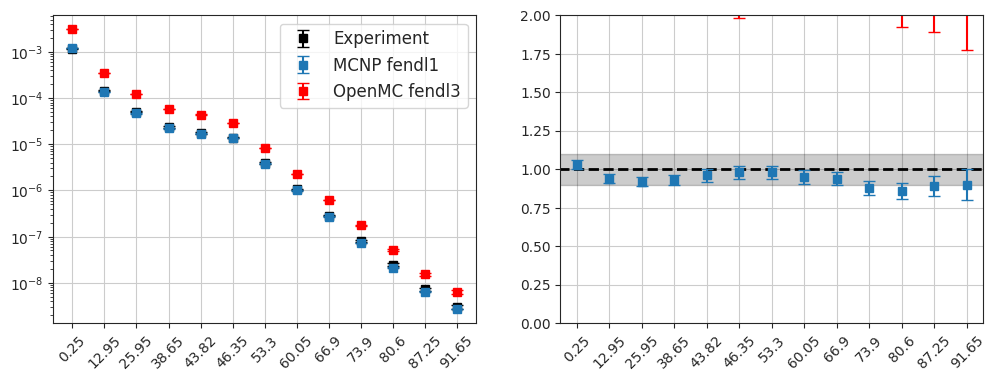

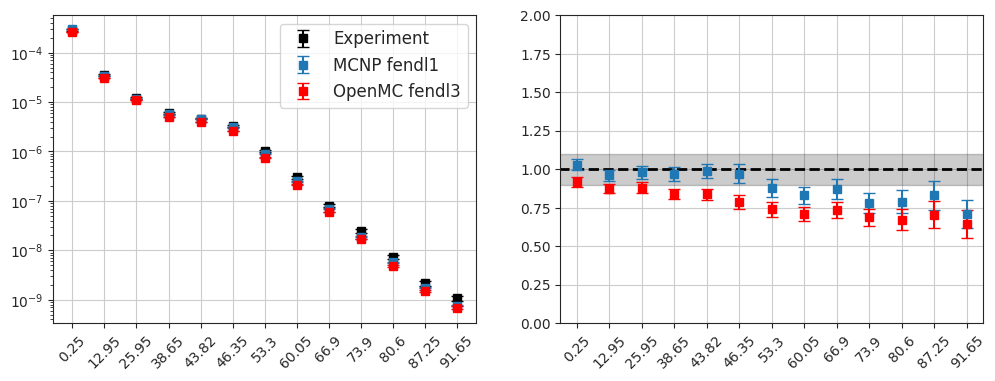

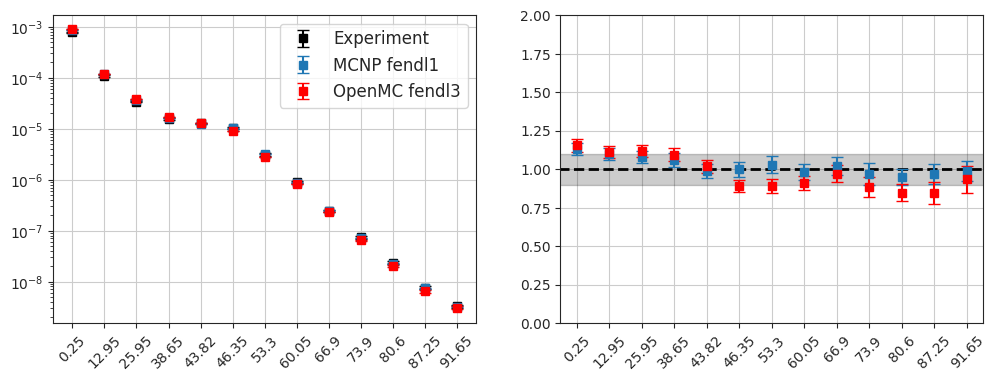

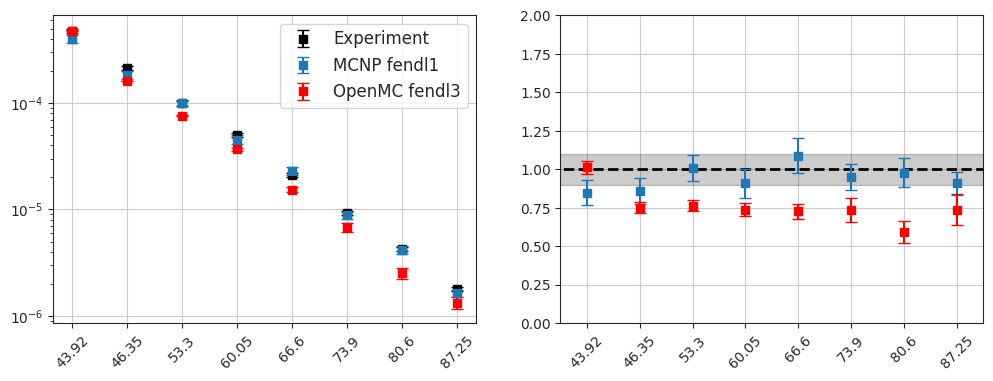

In [10]:
# Tables 5 and 9 results
for i,n in enumerate(nuclides):    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax1.errorbar(np.arange(len(tab5_measured_rr[i])), tab5_measured_rr[i]['E'], tab5_measured_rr[i]['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
    ax1.errorbar(np.arange(len(tab9_mcnp_rr[i])), tab9_mcnp_rr[i]['C FENDL-1'], tab9_mcnp_rr[i]['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP-fendl1')
    ax1.errorbar(np.arange(len(tab9_omc_rr[i])), tab9_omc_rr[i]['mean'], tab9_omc_rr[i]['std. dev.'], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC-fendl3.2')
    ax1.set_yscale('log')
    ax1.set_xticks(np.arange(len(tab9_mcnp_rr[i])))
    ax1.set_xticklabels(tab9_mcnp_rr[i]['y(cm)'])
    ax1.tick_params(axis='x', labelrotation = 45)
    ax1.legend(frameon=True, fontsize=12)
    ax1.grid()
    #
    ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
    ax2.errorbar(np.arange(len(tab9_mcnp_ce[i][0])), tab9_mcnp_ce[i][0], tab9_mcnp_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP-fendl1')
    ax2.errorbar(np.arange(len(tab9_omc_ce[i][0])), tab9_omc_ce[i][0], tab9_omc_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC-fendl3.2')
    ax2.set_xlim([-.5, len(tab9_mcnp_ce[i][0])-.5])
    ax2.set_ylim([0, 2])
    ax2.set_xticks(np.arange(len(tab9_mcnp_ce[i][0])))
    ax2.set_xticklabels(tab9_mcnp_rr[i]['y(cm)'])
    ax2.tick_params(axis='x', labelrotation = 45)
    ax2.grid()

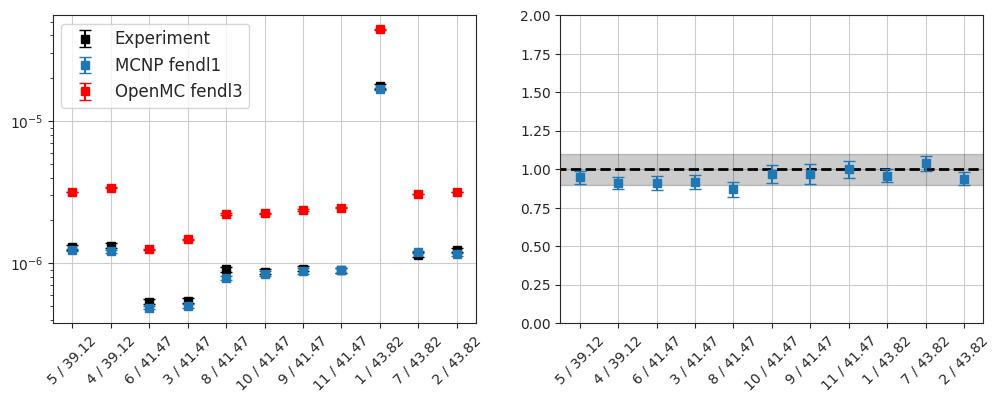

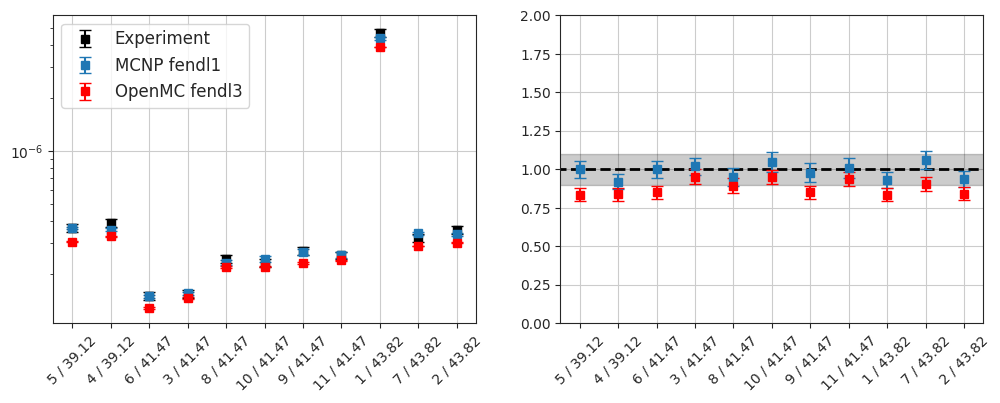

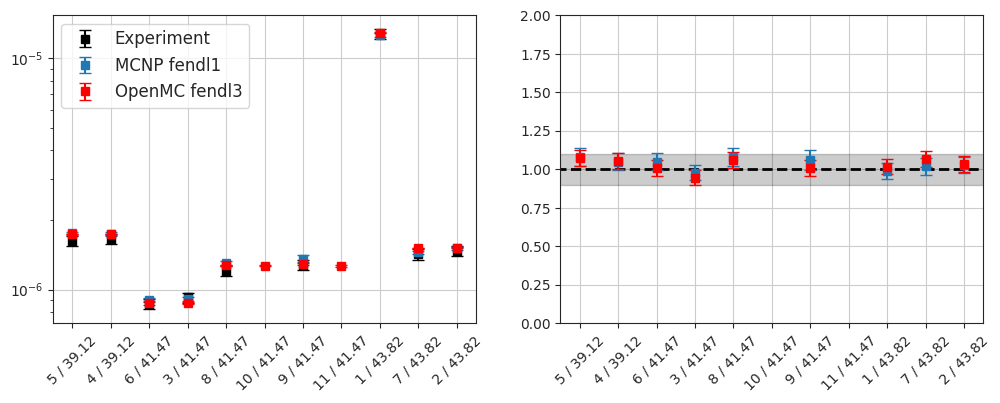

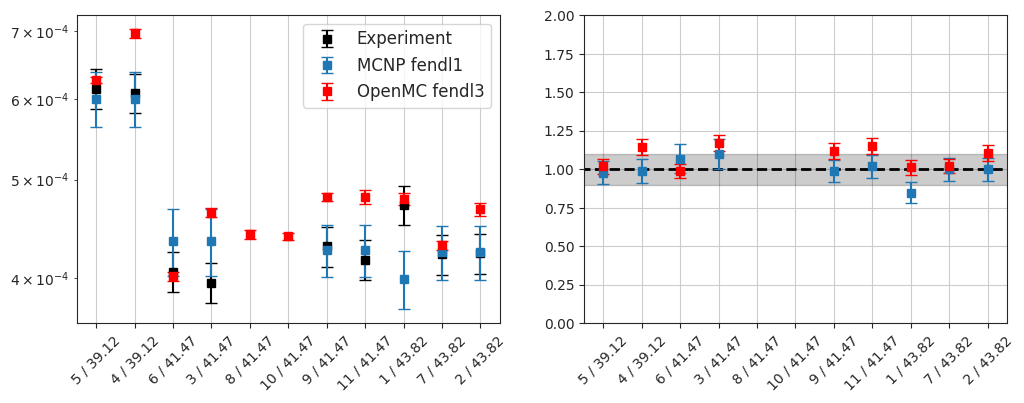

In [11]:
# Tables 6 and 10 results
for i,n in enumerate(nuclides):    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax1.errorbar(np.arange(len(tab6_measured_rr[i])), tab6_measured_rr[i]['E'], tab6_measured_rr[i]['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
    ax1.errorbar(np.arange(len(tab10_mcnp_rr[i])), tab10_mcnp_rr[i]['C FENDL-1'], tab10_mcnp_rr[i]['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
    ax1.errorbar(np.arange(len(tab10_omc_rr[i])), tab10_omc_rr[i]['mean'], tab10_omc_rr[i]['std. dev.'], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
    ax1.set_yscale('log')
    ax1.set_xticks(np.arange(len(tab10_mcnp_rr[i])))
    ax1.set_xticklabels(tab10_mcnp_rr[i]['Position/y(cm)'])
    ax1.tick_params(axis='x', labelrotation = 45)
    ax1.legend(frameon=True, fontsize=12)
    ax1.grid()
    #
    ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
    ax2.errorbar(np.arange(len(tab10_mcnp_ce[i][0])), tab10_mcnp_ce[i][0], tab10_mcnp_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
    ax2.errorbar(np.arange(len(tab10_omc_ce[i][0])), tab10_omc_ce[i][0], tab10_omc_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
    ax2.set_xlim([-.5, len(tab10_mcnp_ce[i][0])-.5])
    ax2.set_ylim([0, 2])
    ax2.set_xticks(np.arange(len(tab10_mcnp_ce[i][0])))
    ax2.set_xticklabels(tab10_mcnp_rr[i]['Position/y(cm)'])
    ax2.tick_params(axis='x', labelrotation = 45)
    ax2.grid()

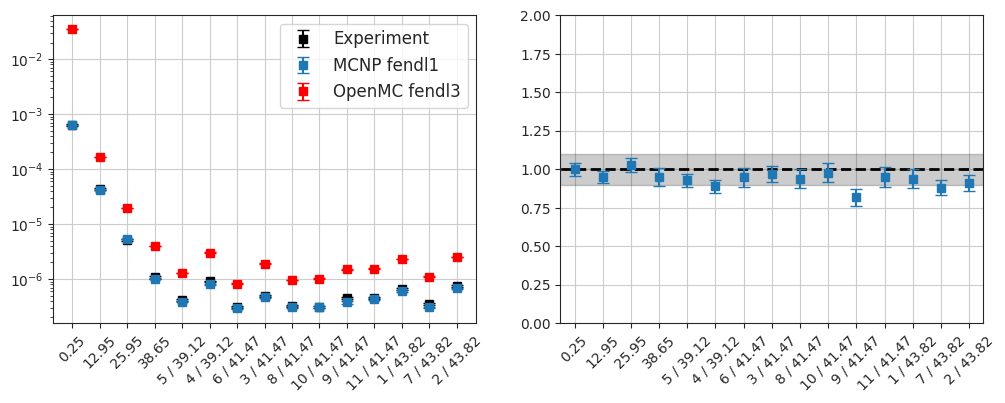

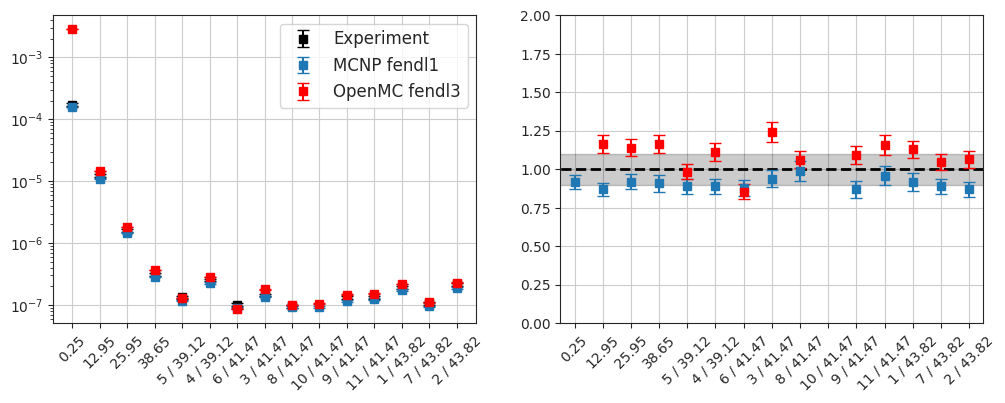

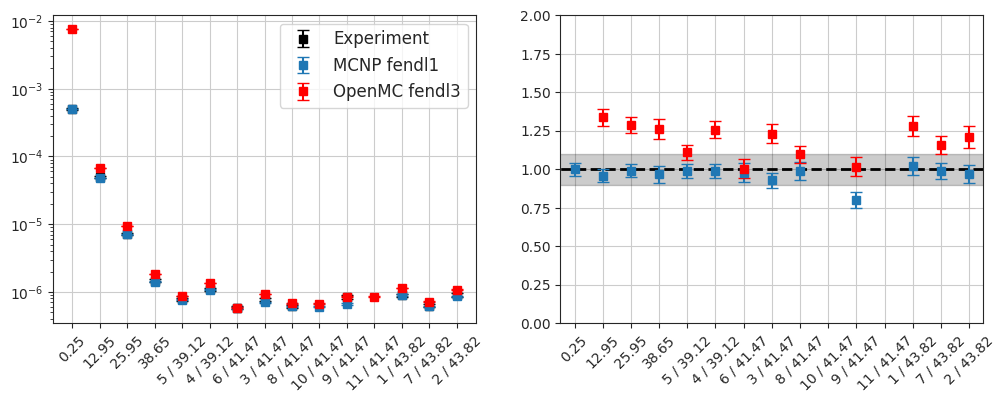

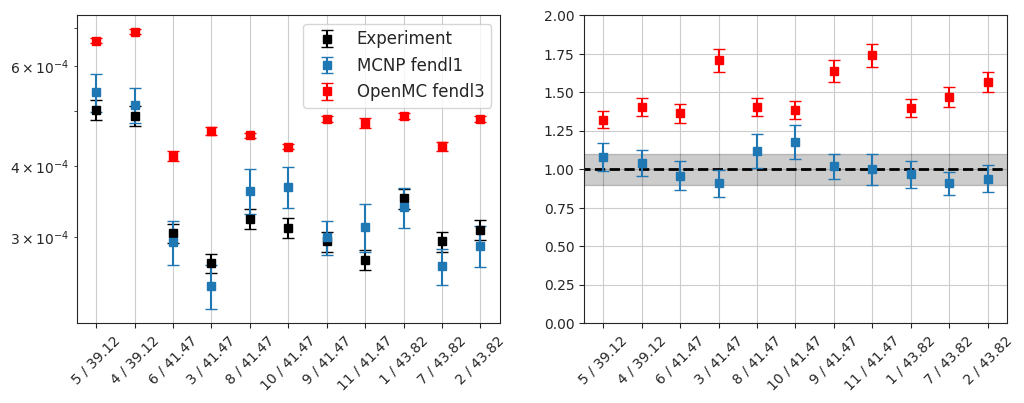

In [12]:
# Tables 7 and 11 results
for i,n in enumerate(nuclides):    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    ax1.errorbar(np.arange(len(tab7_measured_rr[i])), tab7_measured_rr[i]['E'], tab7_measured_rr[i]['Error on E'], marker='s', ms=6, ls='none', capsize=4, color='k', label='Experiment')
    ax1.errorbar(np.arange(len(tab11_mcnp_rr[i])), tab11_mcnp_rr[i]['C FENDL-1'], tab11_mcnp_rr[i]['FENDL-1 err'], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
    ax1.errorbar(np.arange(len(tab11_omc_rr[i])), tab11_omc_rr[i]['mean'], tab11_omc_rr[i]['std. dev.'], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
    ax1.set_yscale('log')
    ax1.set_xticks(np.arange(len(tab11_mcnp_rr[i])))
    ax1.set_xticklabels(tab11_mcnp_rr[i]['Position/y(cm)'])
    ax1.tick_params(axis='x', labelrotation = 45)
    ax1.legend(frameon=True, fontsize=12)
    ax1.grid()
    #
    ax2.fill_between(np.arange(-1,20,1), 0.9*np.ones(21), 1.1*np.ones(21), step='pre', color='k', alpha=0.2)
    ax2.hlines(1.0, -1, 20, colors='k', linestyles='--', linewidth=2)
    ax2.errorbar(np.arange(len(tab11_mcnp_ce[i][0])), tab11_mcnp_ce[i][0], tab11_mcnp_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='tab:blue', label='MCNP fendl1')
    ax2.errorbar(np.arange(len(tab11_omc_ce[i][0])), tab11_omc_ce[i][0], tab11_omc_ce[i][1], marker='s', ms=6, ls='none', capsize=4, color='red', label='OpenMC fendl3')
    ax2.set_xlim([-.5, len(tab11_mcnp_ce[i][0])-.5])
    ax2.set_ylim([0, 2])
    ax2.set_xticks(np.arange(len(tab11_mcnp_ce[i][0])))
    ax2.set_xticklabels(tab11_mcnp_rr[i]['Position/y(cm)'])
    ax2.tick_params(axis='x', labelrotation = 45)
    ax2.grid()